### LSTMs for Question Answering:
#### From these  results, we  can conclude that RNNs have limited capacity for storing large pieces of information. The performance drops signficantly after 41 words.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import keras
import keras.utils
from keras import layers
from keras.layers import merge
from keras.layers import Flatten
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.layers import Activation, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import re


Using TensorFlow backend.


In [2]:
import os
import sys
#train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
#test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

In [3]:
def create_tokenizer(trainingdata, testdata):
    f=open(trainingdata, "r")
    text=[]

    for line in f:
        m=re.match("^\d+\s([^\.]+)[\.].*",line.rstrip())
        if m:
            text.append(m.group(1))
        else:
            m=re.match("^\d+\s([^\?]+)[\?]\s\t([^\t]+)",line.rstrip())
            if m:
                text.append(m.group(1)+' '+m.group(2))
    f.close()

    f=open(testdata, "r")
    for line in f:
        m=re.match("^\d+\s([^\.]+)[\.].*",line.rstrip())
        if m:
            text.append(m.group(1))
        else:
            m=re.match("^\d+\s([^\?]+)[\?].*",line.rstrip())
            if m:
                text.append(m.group(1))
    f.close()

    vocabulary=set([word for word in text])
    max_words = len(vocabulary)
    tokenizer = Tokenizer(num_words=max_words, char_level=False, split=' ')
    tokenizer.fit_on_texts(text)
    #max_story_len = 28
    #max_query_len = 5
    return tokenizer, max_words

In [16]:
def process_stories_n_context(filename,tokenizer,vocab_size,use_context=context):
    f=open(filename,"r")
    X=[]
    Q=[]
    y=[]
    max_story_len=0
    max_query_len=0

    for line in f:
        m=re.match("^(\d+)\s(.+)\.",line.rstrip())
        if m:
            if int(m.group(1))==1:
                story={}
            story[int(m.group(1))]=m.group(2)
        else:
            m=re.match("^\d+\s(.+)\?\s\t([^\t]+)\t(.+)",line.rstrip())
            if m:
                question=m.group(1)
                answer=m.group(2)
                answer_ids=[int(x) for x in m.group(3).split(" ")]
                facts=' '.join([story[id] for id in answer_ids])
                all_facts=' '.join([story[id] for id in story])
                facts_v=vectorize(facts,tokenizer)
                all_facts_v=vectorize(all_facts,tokenizer)

                if use_context==0:
                    vectorized_fact=facts_v
                elif use_context==-1:
                    vectorized_fact=all_facts_v
                else:
                    x=min(use_context, len(story))
                    facts=' '.join([story[id] for id in answer_ids])+' '
                    n=0
                    for id in story:
                        if n<x and id not in answer_ids:
                            facts+=story[id]+' '
                            n+=1
                    vectorized_fact=vectorize(facts,tokenizer)
                l=len(vectorized_fact)
                if l>max_story_len:
                    max_story_len=l
                vectorized_question=vectorize(question,tokenizer)
                l=len(vectorized_question)
                if l>max_query_len:
                    max_query_len=l

                vectorized_answer=vectorize(answer,tokenizer)

                X.append(vectorized_fact)
                Q.append(vectorized_question)
                answer=np.zeros(vocab_size)
                answer[vectorized_answer[0]]=1
                y.append(answer)
    f.close()

    return np.array(X),np.array(Q),np.array(y), max_story_len, max_query_len

In [12]:
def vectorize(s, tokenizer):
    vector=tokenizer.texts_to_sequences([s])
    return vector[0]

In [13]:
def create_model_lstm(trainingData, testData, context):
    tokenizer,vocab_size=create_tokenizer(trainingData,testData)

    X_tr,Q_tr,y_tr,max_story_len_tr, max_query_len_tr=process_stories_n_context(trainingData,tokenizer,vocab_size,use_context=context)
    X_te,Q_te,y_te, max_story_len_te, max_query_len_te=process_stories_n_context(testData,tokenizer,vocab_size,use_context=context)

    max_story_len=max(max_story_len_tr, max_story_len_te)
    max_query_len=max(max_query_len_tr, max_query_len_te)

    X_tr=pad_sequences(X_tr,max_story_len)
    Q_tr=pad_sequences(Q_tr, max_query_len)
    X_te=pad_sequences(X_te,max_story_len)
    Q_te=pad_sequences(Q_te,max_query_len)

    embedding=layers.Embedding(vocab_size,100)

    story = layers.Input(shape=(max_story_len,), dtype='int32')
    encoded_story = embedding(story)
    encoded_story = LSTM(30)(encoded_story)

    question = layers.Input(shape=(max_query_len,), dtype='int32')
    encoded_question = embedding(question)
    encoded_question = LSTM(30)(encoded_question)

    merged = layers.concatenate([encoded_story, encoded_question])
    preds = layers.Dense(vocab_size, activation='softmax')(merged)

    model = Model([story, question], preds)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    #print(X_te,Q_te)

    return X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model



In [14]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

context=0
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model1=create_model_lstm(train,test,context)
print('Training')
history1=model1.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)
print('Evaluation for context=0')
loss1, acc1 = model1.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss1, acc1))


Instructions for updating:
Colocations handled automatically by placer.
Training
Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 6s 688us/step - loss: 1.6309 - acc: 0.7474 - val_loss: 0.3106 - val_acc: 1.0000
Epoch 2/30
9000/9000 [==============================] - 4s 413us/step - loss: 0.1297 - acc: 1.0000 - val_loss: 0.0561 - val_acc: 1.0000
Epoch 3/30
9000/9000 [==============================] - 3s 355us/step - loss: 0.0373 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 1.0000
Epoch 4/30
9000/9000 [==============================] - 4s 461us/step - loss: 0.0192 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 5/30
9000/9000 [==============================] - 4s 460us/step - loss: 0.0120 - acc: 1.0000 - val_loss: 0.0098 - val_acc: 1.0000
Epoch 6/30
9000/9000 [==============================] - 4s 490us/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 7

In [15]:
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

context=2
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model2=create_model_lstm(train,test,context)

print('Training')
history2=model2.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=2')
loss2, acc2 = model2.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss2, acc2))

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 24s 3ms/step - loss: 2.2066 - acc: 0.1650 - val_loss: 1.7951 - val_acc: 0.1680
Epoch 2/30
9000/9000 [==============================] - 7s 790us/step - loss: 1.7924 - acc: 0.1814 - val_loss: 1.6972 - val_acc: 0.2850
Epoch 3/30
9000/9000 [==============================] - 8s 856us/step - loss: 1.4673 - acc: 0.3346 - val_loss: 1.3112 - val_acc: 0.3230
Epoch 4/30
9000/9000 [==============================] - 7s 832us/step - loss: 1.2409 - acc: 0.3403 - val_loss: 1.1913 - val_acc: 0.3330
Epoch 5/30
9000/9000 [==============================] - 8s 868us/step - loss: 1.1858 - acc: 0.3428 - val_loss: 1.1618 - val_acc: 0.4090
Epoch 6/30
9000/9000 [==============================] - 7s 772us/step - loss: 0.7708 - acc: 0.6559 - val_loss: 0.3742 - val_acc: 0.8080
Epoch 7/30
9000/9000 [==============================] - 7s 734us/step - loss: 0.3057 - acc: 0.8350 - val_loss: 0.2834 - val_acc:

In [17]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')


context=4
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model3=create_model_lstm(train,test,context)

print('Training')
history3=model3.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=4')
loss3, acc3 = model3.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss3, acc3))

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 12s 1ms/step - loss: 2.1993 - acc: 0.1662 - val_loss: 1.7951 - val_acc: 0.1750
Epoch 2/30
9000/9000 [==============================] - 11s 1ms/step - loss: 1.7995 - acc: 0.1641 - val_loss: 1.7933 - val_acc: 0.1720
Epoch 3/30
9000/9000 [==============================] - 12s 1ms/step - loss: 1.7977 - acc: 0.1677 - val_loss: 1.7924 - val_acc: 0.1590
Epoch 4/30
9000/9000 [==============================] - 10s 1ms/step - loss: 1.7964 - acc: 0.1699 - val_loss: 1.7919 - val_acc: 0.1590
Epoch 5/30
9000/9000 [==============================] - 7s 783us/step - loss: 1.7955 - acc: 0.1738 - val_loss: 1.7916 - val_acc: 0.1690
Epoch 6/30
9000/9000 [==============================] - 7s 823us/step - loss: 1.7949 - acc: 0.1756 - val_loss: 1.7916 - val_acc: 0.1760
Epoch 7/30
9000/9000 [==============================] - 8s 834us/step - loss: 1.7944 - acc: 0.1754 - val_loss: 1.7917 - val_acc: 0.

In [18]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')


context=6
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model4=create_model_lstm(train,test,context)

history4=model4.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=6')
loss4, acc4 = model4.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss4, acc4))

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 14s 2ms/step - loss: 2.1772 - acc: 0.1674 - val_loss: 1.7946 - val_acc: 0.1750
Epoch 2/30
9000/9000 [==============================] - 10s 1ms/step - loss: 1.7989 - acc: 0.1657 - val_loss: 1.7928 - val_acc: 0.1660
Epoch 3/30
9000/9000 [==============================] - 9s 1ms/step - loss: 1.7967 - acc: 0.1704 - val_loss: 1.7924 - val_acc: 0.1850
Epoch 4/30
9000/9000 [==============================] - 9s 1ms/step - loss: 1.7953 - acc: 0.1756 - val_loss: 1.7927 - val_acc: 0.1810
Epoch 5/30
9000/9000 [==============================] - 10s 1ms/step - loss: 1.7944 - acc: 0.1802 - val_loss: 1.7931 - val_acc: 0.1820
Epoch 6/30
9000/9000 [==============================] - 9s 1ms/step - loss: 1.7939 - acc: 0.1804 - val_loss: 1.7933 - val_acc: 0.1720
Epoch 7/30
9000/9000 [==============================] - 9s 1ms/step - loss: 1.7935 - acc: 0.1816 - val_loss: 1.7934 - val_acc: 0.1720
Epoch 8/30


In [19]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

context5=-1
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model5=create_model_lstm(train,test,context5)
print('Training')

history5=model5.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=All')
loss5, acc5 = model5.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss5, acc5))
#pred=model.pred()

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 17s 2ms/step - loss: 2.1422 - acc: 0.3191 - val_loss: 1.5808 - val_acc: 0.5380
Epoch 2/30
9000/9000 [==============================] - 12s 1ms/step - loss: 1.4696 - acc: 0.5426 - val_loss: 1.4322 - val_acc: 0.5380
Epoch 3/30
9000/9000 [==============================] - 12s 1ms/step - loss: 1.4024 - acc: 0.5426 - val_loss: 1.3749 - val_acc: 0.5380
Epoch 4/30
9000/9000 [==============================] - 12s 1ms/step - loss: 1.2829 - acc: 0.5424 - val_loss: 1.2434 - val_acc: 0.5200
Epoch 5/30
9000/9000 [==============================] - 12s 1ms/step - loss: 1.1668 - acc: 0.5403 - val_loss: 1.1709 - val_acc: 0.5100
Epoch 6/30
9000/9000 [==============================] - 14s 2ms/step - loss: 1.1114 - acc: 0.5368 - val_loss: 1.1386 - val_acc: 0.5160
Epoch 7/30
9000/9000 [==============================] - 12s 1ms/step - loss: 1.0804 - acc: 0.5389 - val_loss: 1.1192 - val_acc: 0.529

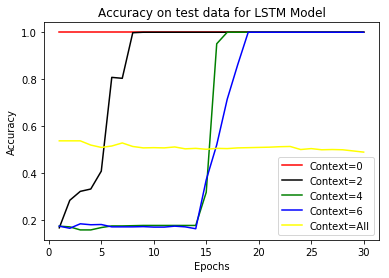

In [21]:
import matplotlib.pyplot as plt
#plt.figsize=(16,4)
history1_dict = history1.history
#history_dict.keys()
history2_dict = history2.history
history3_dict = history3.history
history4_dict = history4.history
history5_dict = history5.history
acc_values1 = history1_dict['val_acc']
acc_values2 = history2_dict['val_acc']
acc_values3 = history3_dict['val_acc']
acc_values4 = history4_dict['val_acc']
acc_values5 = history5_dict['val_acc']
epochs = range(1, len(history1_dict['acc']) + 1)
plt.plot(epochs,  acc_values1, 'b', label='Context=0',color='red')
plt.plot(epochs, acc_values2, 'b', label='Context=2', color='black')
plt.plot(epochs, acc_values3, 'b', label='Context=4', color='green')
plt.plot(epochs, acc_values4, 'b', label='Context=6', color='blue')
plt.plot(epochs, acc_values5, 'b', label='Context=All', color='yellow')
plt.title('Accuracy on test data for LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


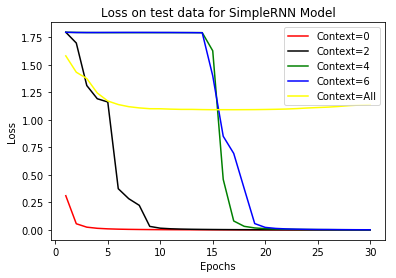

In [22]:
import matplotlib.pyplot as plt
#plt.figsize=(16,4)
history1_dict = history1.history
#history_dict.keys()
history2_dict = history2.history
history3_dict = history3.history
history4_dict = history4.history
history5_dict = history5.history
loss_values1 = history1_dict['val_loss']
loss_values2 = history2_dict['val_loss']
loss_values3 = history3_dict['val_loss']
loss_values4 = history4_dict['val_loss']
loss_values5 = history5_dict['val_loss']
epochs = range(1, len(history1_dict['acc']) + 1)
plt.plot(epochs,  loss_values1, 'b', label='Context=0',color='red')
plt.plot(epochs, loss_values2, 'b', label='Context=2', color='black')
plt.plot(epochs, loss_values3, 'b', label='Context=4', color='green')
plt.plot(epochs, loss_values4, 'b', label='Context=6', color='blue')
plt.plot(epochs, loss_values5, 'b', label='Context=All', color='yellow')
plt.title('Loss on test data for SimpleRNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
